In [99]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


In [100]:
df = pd.read_csv("QVI_data.csv")

print(df)

        LYLTY_CARD_NBR        DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0                 1000  2018-10-17          1       1         5   
1                 1002  2018-09-16          1       2        58   
2                 1003  2019-03-07          1       3        52   
3                 1003  2019-03-08          1       4       106   
4                 1004  2018-11-02          1       5        96   
...                ...         ...        ...     ...       ...   
264829         2370701  2018-12-08         88  240378        24   
264830         2370751  2018-10-01         88  240394        60   
264831         2370961  2018-10-24         88  240480        70   
264832         2370961  2018-10-27         88  240481        65   
264833         2373711  2018-12-14         88  241815        16   

                                       PROD_NAME  PROD_QTY  TOT_SALES  \
0         Natural Chip        Compny SeaSalt175g         2        6.0   
1          Red Rock Deli Chikn&Garlic Aioli 150g 

The client has selected store numbers 77, 86 and 88 as trial stores and want control stores to be established
stores that are operational for the entire observation period.
We would want to match trial stores to control stores that are similar to the trial store prior to the trial period
of Feb 2019 in terms of:
• Monthly overall sales revenue
• Monthly number of customers
• Monthly number of transactions per customer
Let’s first create the metrics of interest and filter to stores that are present throughout the pre-trial period

In [104]:
df['MONTH'] =  pd.to_datetime(df['DATE'],format='%Y-%m-%d').dt.to_period('M')
df['MONTH']
aggregated = df.groupby(['STORE_NBR', 'MONTH']).agg(
    TOT_SALES=('TOT_SALES', 'sum'),
    NUM_CUSTOMERS=('LYLTY_CARD_NBR', pd.Series.nunique),
    NUM_TRANSACTIONS=('TXN_ID', 'count'),
    AVG_QTY=('PROD_QTY', 'mean'),
    TOT_QTY=('PROD_QTY', 'sum')
)

aggregated['PRICE_PER_UNIT'] = aggregated['TOT_SALES'] / aggregated['TOT_QTY']

# filter to only stores with 12 months
store_counts = df.groupby('STORE_NBR')['MONTH'].nunique()
stores_with_12_months = store_counts[store_counts == 12].index
aggregated = aggregated[aggregated.index.get_level_values('STORE_NBR').isin(stores_with_12_months)]


pretrial_measures = aggregated[aggregated.index.get_level_values('MONTH') < '2019-02']
pretrial_measures

TOT_SALES  NUM_CUSTOMERS  NUM_TRANSACTIONS   AVG_QTY  \
STORE_NBR MONTH                                                           
1         2018-07      206.9             49                52  1.192308   
          2018-08      176.1             42                43  1.255814   
          2018-09      278.8             59                62  1.209677   
          2018-10      188.1             44                45  1.288889   
          2018-11      192.6             46                47  1.212766   
...                      ...            ...               ...       ...   
272       2018-09      304.7             32                36  1.972222   
          2018-10      430.6             44                51  1.941176   
          2018-11      376.2             41                45  1.933333   
          2018-12      403.9             47                47  1.893617   
          2019-01      423.0             46                50  1.920000   

                   TOT_QTY  PRICE_PER_UNIT  
STORE_NBR MONTH                             
1         2018-07       62        3.337097  
          2018-08       54        3.261111  
          2018-09       75        3.717333  
          2018-10       58        3.243103  
          2018-11       57        3.378947  
...                    ...             ...  
272       2018-09       71        4.291549  
          2018-10       99        4.349495  
          2018-11       87        4.324138  
          2018-12       89        4.538202  
          2019-01       96        4.406250  

[1820 rows x 6 columns]

In [105]:
def calculate_correlation(df, metric, store_comparison):
    store_numbers = aggregated.index.get_level_values('STORE_NBR').unique()
    correlation_table = pd.DataFrame(columns=["Store1", "Store2", "corr_measure"])
    sample_c = df[df.index.get_level_values('STORE_NBR') == store_comparison][metric]
    for i in store_numbers:
        sample_i = df[df.index.get_level_values('STORE_NBR') == i][metric]
        corr = pearsonr(sample_c, sample_i)[0]
        correlation_table = pd.concat([correlation_table, pd.DataFrame([[store_comparison, i, corr]], columns=["Store1", "Store2", "corr_measure"])], ignore_index=True)
    correlation_table = correlation_table.sort_values(by=['corr_measure'], ascending=False)
    return correlation_table


corr_sales = calculate_correlation(pretrial_measures, 'TOT_SALES', 77)
corr_num_custs = calculate_correlation(pretrial_measures, 'NUM_CUSTOMERS', 77)

print("correlations in total sales")
print(corr_sales)
print("correlations in number of customers")
print(corr_num_custs)


/var/folders/rq/9wbc2l4d50z5b952bfndzkd40000gn/T/ipykernel_1114/1568319792.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_table = pd.concat([correlation_table, pd.DataFrame([[store_comparison, i, corr]], columns=["Store1", "Store2", "corr_measure"])], ignore_index=True)
/var/folders/rq/9wbc2l4d50z5b952bfndzkd40000gn/T/ipykernel_1114/1568319792.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_table = pd.concat([correlation_table, pd.DataFrame([[store_comparison, i,

correlations in total sales
    Store1 Store2  corr_measure
72      77     77      1.000000
67      77     71      0.914106
221     77    233      0.903774
111     77    119      0.867664
15      77     17      0.842668
..     ...    ...           ...
150     77    158     -0.709319
22      77     24     -0.718112
232     77    244     -0.774513
71      77     75     -0.806751
178     77    186     -0.820214

[260 rows x 3 columns]
correlations in number of customers
    Store1 Store2  corr_measure
72      77     77      1.000000
221     77    233      0.990358
111     77    119      0.983267
241     77    254      0.916208
106     77    113      0.901348
..     ...    ...           ...
95      77    102     -0.652527
139     77    147     -0.656933
161     77    169     -0.666391
50      77     54     -0.760605
8       77      9     -0.785699

[260 rows x 3 columns]


In [ ]:
def calculate_magnitude(df, metric, store_comparison):
    store_numbers = aggregated.index.get_level_values('STORE_NBR').unique()
    dist_table = pd.DataFrame(columns=["Store1", "Store2", "dist_measure"])
    sample_c = df[df.index.get_level_values('STORE_NBR') == store_comparison][metric].reset_index(drop=True)
    for i in store_numbers:
        sample_i = df[df.index.get_level_values('STORE_NBR') == i][metric].reset_index(drop=True)
        dist = np.linalg.norm(sample_i - sample_c)
        dist_table = pd.concat([dist_table, pd.DataFrame([[store_comparison, i, dist]], columns=["Store1", "Store2", "dist_measure"])], ignore_index=True)

    min_dist = dist_table['dist_measure'].min()
    max_dist = dist_table['dist_measure'].max()
    dist_table['mag_measure'] = 1 - (dist_table['dist_measure'] - min_dist) / (max_dist - min_dist)
    dist_table = dist_table.sort_values(by=['mag_measure'], ascending=False)
    return dist_table


dist_sales = calculate_magnitude(pretrial_measures, 'TOT_SALES', 77)
dist_num_custs = calculate_magnitude(pretrial_measures, 'NUM_CUSTOMERS', 77)

print(dist_sales)
print(dist_num_custs)


    Store1 Store2  dist_measure  mag_measure
72      77     77      0.000000     1.000000
221     77    233     57.809342     0.982207
49      77     53     98.777275     0.969597
46      77     50    100.672340     0.969014
42      77     46    101.582085     0.968734
..     ...    ...           ...          ...
157     77    165   2857.488660     0.120480
54      77     58   2869.987250     0.116633
225     77    237   2903.293984     0.106381
82      77     88   2908.804057     0.104685
214     77    226   3248.918500     0.000000

[260 rows x 4 columns]
    Store1 Store2  dist_measure  mag_measure
72      77     77      0.000000     1.000000
221     77    233      2.645751     0.989325
38      77     41      7.681146     0.969008
104     77    111     10.535654     0.957490
15      77     17     10.723805     0.956731
..     ...    ...           ...          ...
157     77    165    214.436471     0.134781
54      77     58    219.697519     0.113553
82      77     88    219.783985

/var/folders/rq/9wbc2l4d50z5b952bfndzkd40000gn/T/ipykernel_1114/2248912971.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_table = pd.concat([dist_table, pd.DataFrame([[store_comparison, i, dist]], columns=["Store1", "Store2", "dist_measure"])], ignore_index=True)
/var/folders/rq/9wbc2l4d50z5b952bfndzkd40000gn/T/ipykernel_1114/2248912971.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_table = pd.concat([dist_table, pd.DataFrame([[store_comparison, i, dist]], columns=["Store1", 

In [ ]:
def calculate_combined_score(store_comparison):
    dist_sales = calculate_magnitude(pretrial_measures, 'TOT_SALES', store_comparison)
    dist_num_custs = calculate_magnitude(pretrial_measures, 'NUM_CUSTOMERS', store_comparison)
    corr_sales = calculate_correlation(pretrial_measures, 'TOT_SALES', store_comparison)
    corr_num_custs = calculate_correlation(pretrial_measures, 'NUM_CUSTOMERS', store_comparison)

    score_sales = pd.merge(corr_sales, dist_sales, on=['Store1', 'Store2'])
    score_sales['sales_score'] = 0.5 * score_sales['corr_measure'] + 0.5 * score_sales['mag_measure']
    score_sales = score_sales.sort_values(by=['sales_score'], ascending=False)

    score_num_custs = pd.merge(corr_num_custs, dist_num_custs, on=['Store1', 'Store2'])
    score_num_custs['num_custs_score'] = 0.5 * score_num_custs['corr_measure'] + 0.5 * score_num_custs['mag_measure']
    score_num_custs = score_num_custs.sort_values(by=['num_custs_score'], ascending=False)

    scores_control = score_num_custs = pd.merge(score_sales, score_num_custs, on=['Store1', 'Store2'])
    scores_control['final_control_score'] = 0.5 * score_num_custs['num_custs_score'] + 0.5 * score_num_custs['sales_score']
    scores_control = score_num_custs.sort_values(by=['final_control_score'], ascending=False)

    return scores_control

print(calculate_combined_score(77)[['Store2', 'final_control_score']])

/var/folders/rq/9wbc2l4d50z5b952bfndzkd40000gn/T/ipykernel_1114/2248912971.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_table = pd.concat([dist_table, pd.DataFrame([[store_comparison, i, dist]], columns=["Store1", "Store2", "dist_measure"])], ignore_index=True)
/var/folders/rq/9wbc2l4d50z5b952bfndzkd40000gn/T/ipykernel_1114/2248912971.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_table = pd.concat([dist_table, pd.DataFrame([[store_comparison, i, dist]], columns=["Store1", 

    Store2  final_control_score
0       77             1.000000
1      233             0.966416
2       41             0.889053
4       17             0.854398
11     254             0.834347
..     ...                  ...
258     55            -0.069800
253    138            -0.080239
255    247            -0.089746
251    102            -0.093771
259     75            -0.207489

[260 rows x 2 columns]


Therefore store 233 is the most correlated for store 77, and will be the control store.

Now let's plot metrics for these two stores together to see if there are similarities.

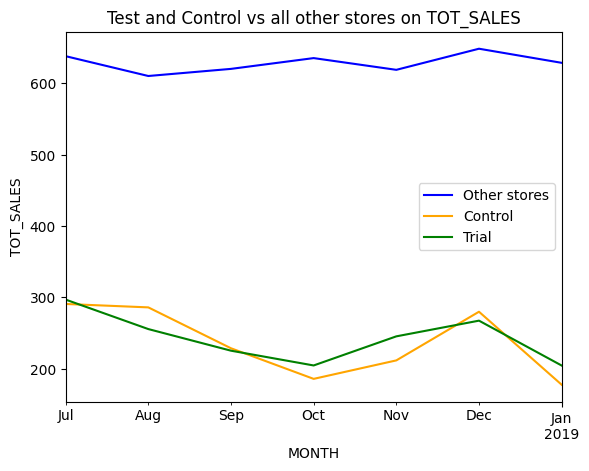

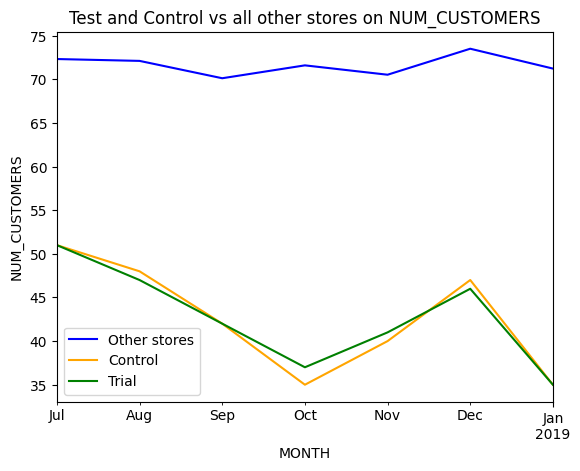

In [ ]:
def plot_ctrl_trial_mean(metric, control, trial):
    control_sales = pretrial_measures[pretrial_measures.index.get_level_values('STORE_NBR') == control][metric].droplevel('STORE_NBR')
    trial_sales = pretrial_measures[pretrial_measures.index.get_level_values('STORE_NBR') == trial][metric].droplevel('STORE_NBR')
    mean_sales = pretrial_measures[~pretrial_measures.index.get_level_values('STORE_NBR').isin([trial, control])].reset_index().groupby('MONTH').agg({metric: "mean"})
    mean_sales.plot(color="blue")
    control_sales.plot(color="orange")
    trial_sales.plot(color="green")
    plt.title("Test and Control vs all other stores on " + str(metric))
    plt.ylabel(metric)
    plt.legend(["Other stores", "Control", "Trial"])
    plt.show()


plot_ctrl_trial_mean('TOT_SALES', 233, 77)
plot_ctrl_trial_mean('NUM_CUSTOMERS', 233, 77)

1.023617303289553
MONTH
2019-02    0.059107
2019-03    0.366521
2019-04    0.623080
Freq: M, Name: TOT_SALES, dtype: float64
MONTH
2019-02    0.641075
2019-03    3.975319
2019-04    6.757975
Freq: M, Name: TOT_SALES, dtype: float64
[0.72905739 0.9973221  0.99986846]
accepted p-values should fall in the range:
[-2.36462425  2.36462425]


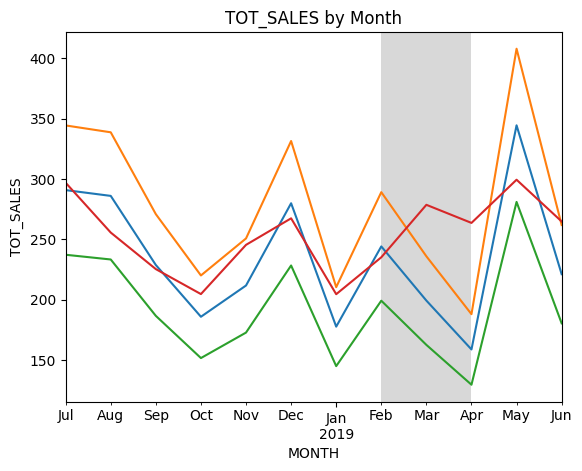

1.0033557046979866
MONTH
2019-02    0.003344
2019-03    0.245819
2019-04    0.561427
Freq: M, Name: NUM_CUSTOMERS, dtype: float64
MONTH
2019-02     0.131649
2019-03     9.676227
2019-04    22.099538
Freq: M, Name: NUM_CUSTOMERS, dtype: float64
[0.55051717 0.99998672 0.99999995]
accepted p-values should fall in the range:
[-2.36462425  2.36462425]


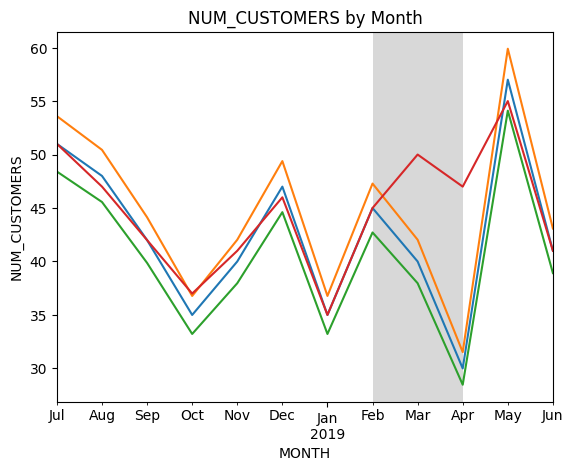

In [ ]:
from scipy.stats import t

trial_measures = aggregated[(aggregated.index.get_level_values('MONTH') >= '2019-02') & (aggregated.index.get_level_values('MONTH') <= '2019-04')]

def assess_trial(metric, control, trial):
    control_sales = pretrial_measures[pretrial_measures.index.get_level_values('STORE_NBR') == control][metric].droplevel('STORE_NBR')
    trial_sales = pretrial_measures[pretrial_measures.index.get_level_values('STORE_NBR') == trial][metric].droplevel('STORE_NBR')
    scale_factor = trial_sales.sum() / control_sales.sum()
    print(scale_factor)

    scaled_control_sales_trial = trial_measures[trial_measures.index.get_level_values('STORE_NBR') == control][metric].droplevel('STORE_NBR') * scale_factor
    trial_sales_trial = trial_measures[trial_measures.index.get_level_values('STORE_NBR') == trial][metric].droplevel('STORE_NBR')
    percentage_diff = abs((trial_sales_trial - scaled_control_sales_trial) / scaled_control_sales_trial)
    print(percentage_diff)

    stdev = np.std(trial_sales / (control_sales * scale_factor))

    t_values = percentage_diff / stdev
    print(t_values)

    print(t.cdf(t_values, 7))
    print("accepted p-values should fall in the range:")
    print(t(df=7).ppf((0.025, 0.975)))

    aggregated[aggregated.index.get_level_values('STORE_NBR') == control][metric].droplevel('STORE_NBR').plot()
    (aggregated[aggregated.index.get_level_values('STORE_NBR') == control][metric].droplevel('STORE_NBR') * (1 + 2*stdev)).plot()
    (aggregated[aggregated.index.get_level_values('STORE_NBR') == control][metric].droplevel('STORE_NBR') * (1 - 2*stdev)).plot()
    aggregated[aggregated.index.get_level_values('STORE_NBR') == trial][metric].droplevel('STORE_NBR').plot()
    plt.axvspan('2019-02', '2019-04', facecolor='gray', alpha=0.3, label='Highlighted Region')
    plt.ylabel(metric)
    plt.title(str(metric) + " by Month")
    plt.show()

assess_trial('TOT_SALES', 233, 77)
assess_trial('NUM_CUSTOMERS', 233, 77)

Now let's repeat these steps for trial stores 86 and 88

In [ ]:
print(calculate_combined_score(86)[['Store2', 'final_control_score']])
print(calculate_combined_score(88)[['Store2', 'final_control_score']])

/var/folders/rq/9wbc2l4d50z5b952bfndzkd40000gn/T/ipykernel_1114/2248912971.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_table = pd.concat([dist_table, pd.DataFrame([[store_comparison, i, dist]], columns=["Store1", "Store2", "dist_measure"])], ignore_index=True)
/var/folders/rq/9wbc2l4d50z5b952bfndzkd40000gn/T/ipykernel_1114/2248912971.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_table = pd.concat([dist_table, pd.DataFrame([[store_comparison, i, dist]], columns=["Store1", 

    Store2  final_control_score
0       86             1.000000
1      155             0.938200
2      109             0.867169
5      114             0.855646
4      138             0.837185
..     ...                  ...
250    108            -0.224162
255     52            -0.288040
257    120            -0.297876
258     42            -0.346109
259    146            -0.354383

[260 rows x 2 columns]


/var/folders/rq/9wbc2l4d50z5b952bfndzkd40000gn/T/ipykernel_1114/2248912971.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_table = pd.concat([dist_table, pd.DataFrame([[store_comparison, i, dist]], columns=["Store1", "Store2", "dist_measure"])], ignore_index=True)
/var/folders/rq/9wbc2l4d50z5b952bfndzkd40000gn/T/ipykernel_1114/2248912971.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dist_table = pd.concat([dist_table, pd.DataFrame([[store_comparison, i, dist]], columns=["Store1", 

    Store2  final_control_score
0       88             1.000000
11     237             0.796020
4      178             0.795610
22      69             0.706325
20     113             0.703886
..     ...                  ...
253     90            -0.172054
183    258            -0.182397
255    141            -0.190504
249    239            -0.192073
256     42            -0.195359

[260 rows x 2 columns]


So the appropriate control stores will be 155 and 237 respectively.

For store 86:

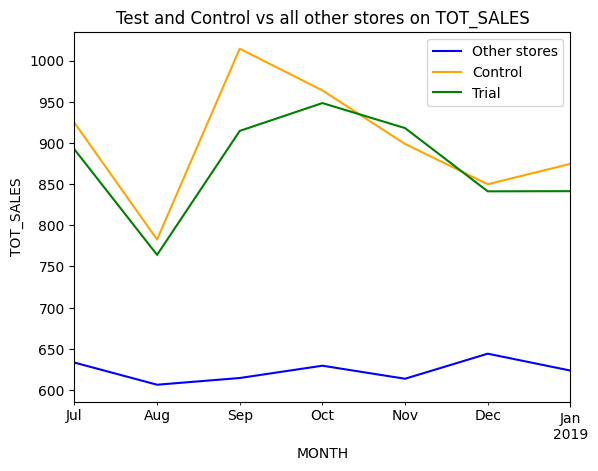

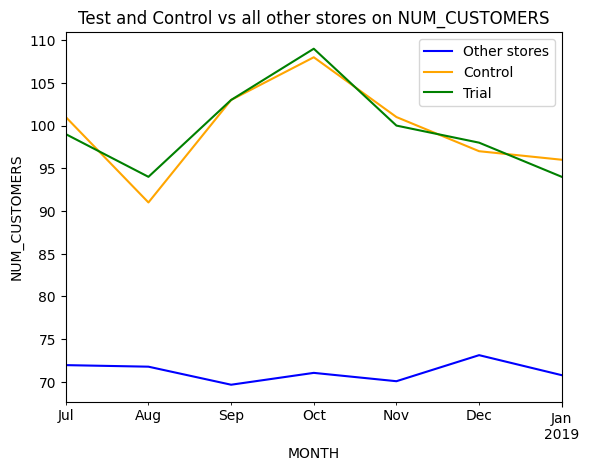

0.9700651481287743
MONTH
2019-02    0.056306
2019-03    0.315870
2019-04    0.035253
Freq: M, Name: TOT_SALES, dtype: float64
MONTH
2019-02    1.613828
2019-03    9.053346
2019-04    1.010395
Freq: M, Name: TOT_SALES, dtype: float64
[0.92470031 0.99997948 0.82702531]
accepted p-values should fall in the range:
[-2.36462425  2.36462425]


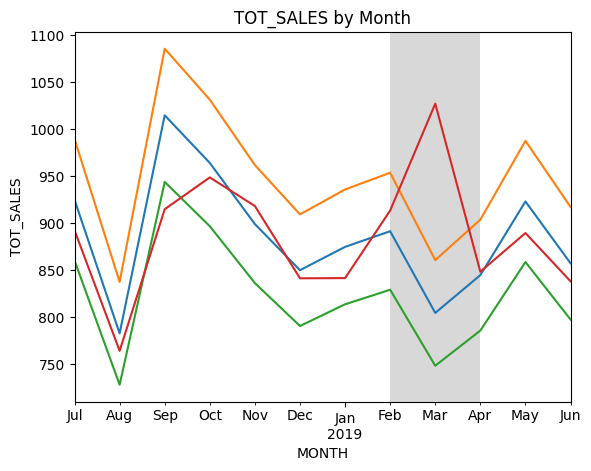

1.0
MONTH
2019-02    0.126316
2019-03    0.223404
2019-04    0.060606
Freq: M, Name: NUM_CUSTOMERS, dtype: float64
MONTH
2019-02     7.121215
2019-03    12.594702
2019-04     3.416745
Freq: M, Name: NUM_CUSTOMERS, dtype: float64
[0.99990496 0.9999977  0.99440761]
accepted p-values should fall in the range:
[-2.36462425  2.36462425]


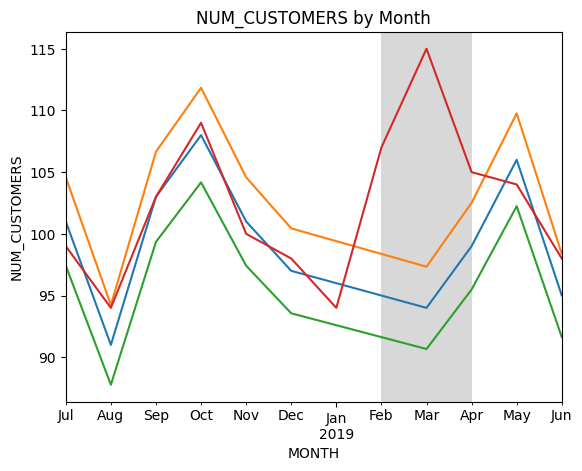

In [120]:
plot_ctrl_trial_mean('TOT_SALES', 155, 86)
plot_ctrl_trial_mean('NUM_CUSTOMERS', 155, 86)

assess_trial('TOT_SALES', 155, 86)
assess_trial('NUM_CUSTOMERS', 155, 86)